The visualization used for this seminar is based on Alexandr Verinov's code.  

# Generative models

In this seminar we will try several criterions for learning an implicit model. For the first part almost everything is written for you, and you only need to implement the objective for the game and play around with the model. 

**0)** Read the code

**1)** Implement objective for a vanilla [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GAN). The hyperparameters are already set in the code. The model will converge if you implement the objective (1) right. 

**2)** Note the discussion in the paper, that the objective for $G$ can be of two kinds: $\min_G \log(1 - D)$ and $\min_G - \log(D)$. Now implement the second objective and ensure model converges. Most likely, in this example you will not notice the difference, but people usually use the second objective, it really matters in more complicated scenarios. **NOTE:** the objective for D stays the same.

**3 & 4)** Implement [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) and WGAN-GP. To make the discriminator has Lipschitz property you need to clip discriminator's weights to $[-0.01, 0.01]$ range (WGAN) or use gradient penalty (WGAN-GP). You will need to make few modifications to the code: 

   - Remove sigmoids from discriminator;
   - Change objective (see eq. 3 and algorithm 1 in [the paper](https://arxiv.org/pdf/1701.07875.pdf)): 
   - Add weight clipping for D [see here](https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py#L172) / gradient penaly (WGAN-GP) [code](https://gist.github.com/DmitryUlyanov/19ce84045135e3f81a477629e685aec8); 

   
In general see [implementation 1](https://github.com/martinarjovsky/WassersteinGAN/blob/master/main.py#L172) / [implementation 2](https://github.com/caogang/wgan-gp). They also use different optimizer. 

The default hyperparameters may not work well, spend some time to tune them -- play with learning rate, number of D updates per one G update, change architecture (what about weight initialization?). 

**5) Bonus: Wasserstein Introspective Neural Networkss**. This is basically WGAN-GP without generator. Read and implement [WINN paper](https://arxiv.org/pdf/1711.08875.pdf) for our toy task. The classification step is almost identical to the discriminative step for WGAN-GP. However on synthesis step, we will not use a generator network, but instead we optimize the same loss as the generator loss in WGAN-GP with respect to the *generated objects* (aka "pseudo-negative samples"). Then, we accumulate the generated "pseudo-negative" samples and use mini-batches from them as the "fake data" for the next classification step.

Here are some tips for you:
- Initialize your "fake dataset" with random noise.
- During the classification stage, sample fake data from the fake dataset.
- For the synthesis step, use the fake samples from the previous step as the initial value.
- You can use an ordinary Adam optimizer to update the samples, but you need to inject small noise on each step (last equation on page 4). Do not forget to early stop after the threshold (page 5, first paragraph) is reached.
- Add the new generated points to the "fake dataset".

To make the visualization work without a generator, you have to supply your generated samples to `vis_points` function.

In [1]:
""" 
    Please, implement everything in one notebook, using if statements to switch between the tasks
"""
# TASK in [1, 2, 3, 4, 5]
TASK = 2

# Imports

In [2]:
import numpy as np
import time
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_num_threads(4)
np.random.seed(12345)
lims=(-5, 5)

# Define sampler from real data and Z 

Some utility functions.

In [3]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

And more utility functions.

In [4]:
def vis_data(data):
    """
        Visualizes data as histogram
    """
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = torch.Tensor(sample_noise(1000))
def vis_g():
    """
        Visualizes generator's samples as circles
    """
    data = generator(fixed_noise).data.numpy()
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
    
def vis_points(data):
    """
        Visualizes the supplied samples as circles
    """
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    

def get_grid():
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
        
    grid = torch.from_numpy(np.vstack([X, Y]).astype(np.float32).T)
    grid.requires_grad = True
                            
    return X, Y, grid
              
X_grid, Y_grid, grid = get_grid()
def vis_d():
    """
        Visualizes discriminator's gradient on grid
    """
        
    data_gen = generator(fixed_noise)
#     loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss = g_loss(discriminator(grid))
    loss.backward()
    
    grads = - grid.grad.data.numpy()
    grid.grad.data *= 0 
    plt.quiver(X_grid, Y_grid, grads[:, 0], grads[:, 1], color='black',alpha=0.9)

# Define architectures

After you've done with task 1 you can play with architectures.

In [5]:
def get_generator(noise_dim, out_dim, hidden_dim=100):
    layers = [
        nn.Linear(noise_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, out_dim)
    ]
    return nn.Sequential(*layers)

def get_discriminator(in_dim, hidden_dim=100):
    layers = [
        nn.Linear(in_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    ]
        
    return nn.Sequential(*layers)

# Define updates and losses

In [6]:
generator = get_generator(NOISE_DIM, out_dim = 2)
discriminator = get_discriminator(in_dim = 2)

lr = 0.001
g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Notice we are using ADAM optimizer with `beta1=0.5` for both discriminator and discriminator. This is a common practice and works well. Motivation: models should be flexible and adapt itself rapidly to the distributions. 

You can try different optimizers and parameters.

In [7]:
################################
#       IMPLEMENT HERE
################################
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement Tasks 1 and 2 

def g_loss(d_scores_fake):
    """
        `d_scores_fake` is the output of the discrimonator model applied to a batch of fake data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1: 
        return torch.mean(torch.log(1 - d_scores_fake))
    elif TASK == 2:
        return -torch.mean(torch.log(d_scores_fake))
    
    return # TODO
    
def d_loss(d_scores_fake, d_scores_real):
    """
        `d_scores_fake` is the output of the discrimonator model applied to a batch of fake data
        `d_scores_real` is the output of the discrimonator model applied to a batch of real data
        
        NOTE: we always define objectives as if we were minimizing them (remember that maximize = negate and minimize)
    """
    if TASK == 1:
#         return torch.mean( torch.cat([torch.log(1- d_scores_fake), torch.log(d_scores_real)], dim=0))
        return -torch.mean(torch.cat([torch.log(1- d_scores_fake) + torch.log(d_scores_real)]))
    elif TASK == 2:
        return -torch.mean(torch.cat([torch.log(1- d_scores_fake), torch.log(d_scores_real)]))
    
    return # TODO

# Get real data

In [8]:
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in range(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

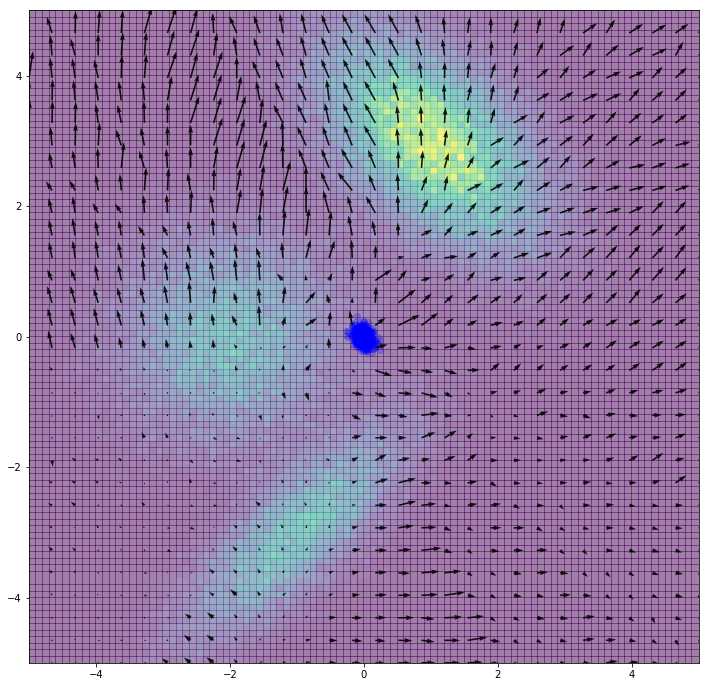

In [9]:
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
vis_d()

**Legend**:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradients of the discriminator -- they are the directions that discriminator pushes generator's samples. 

# Train the model

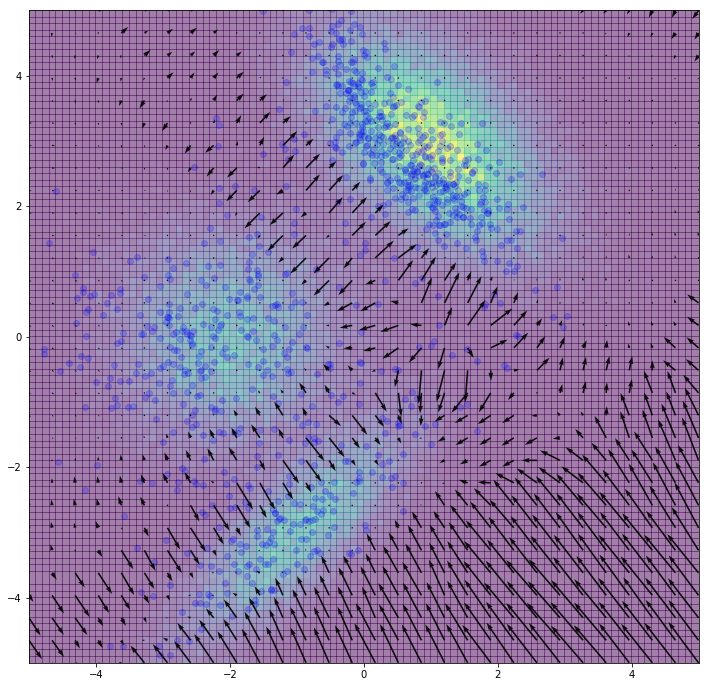

Task 2; Iteration 1562


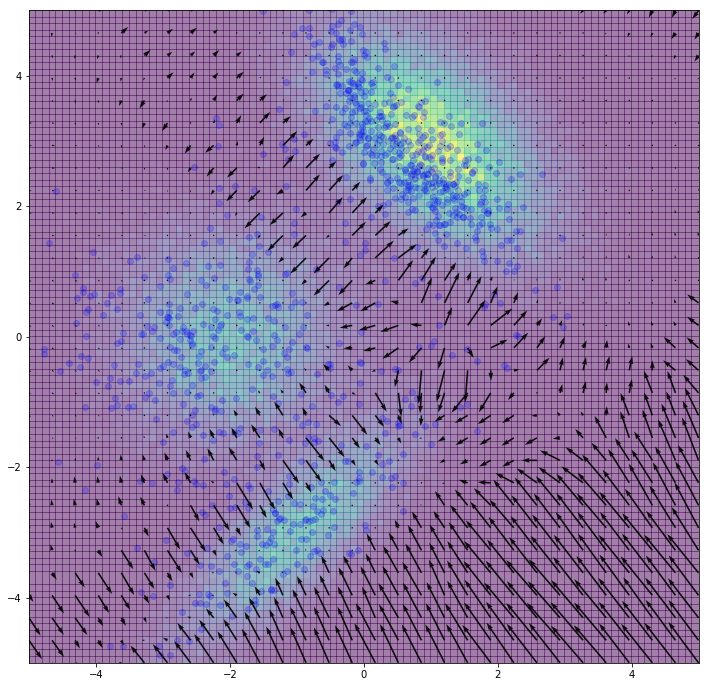

In [10]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 1, 1

try:
    for it, real_data in enumerate(iterate_minibatches(data, batch_size)):

        # Optimize D
        for _ in range(k_d):
            d_optimizer.zero_grad()
            
            # Sample noise
            noise = torch.Tensor(sample_noise(real_data.shape[0]))

            # Compute gradient
            real_data = torch.Tensor(real_data)
            fake_data = generator(noise)
            loss = d_loss(discriminator(fake_data), discriminator(real_data))            
            loss.backward()
            
            # IMPLEMENT HERE GP FOR TASK 4
                
            # Update
            d_optimizer.step()

        # Optimize G
        for _ in range(k_g):
            g_optimizer.zero_grad()
            
            # Sample noise
            noise = torch.Tensor(sample_noise(real_data.shape[0]))

            # Compute gradient
            fake_data = generator(noise)
            loss = g_loss(discriminator(fake_data))
            loss.backward()
            
            # Update
            g_optimizer.step()

        # Visualize
        if it % 2 == 0:
            plt.clf()
            vis_data(data)
            
            if TASK < 5:
                vis_g()
            else:
                pass
                # UNCOMMENT AND SUPPLY YOUR SAMPLES FOR BONUS TASK 5
                # vis_points(generated_samples[-1000:])
            vis_d()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print(f"Task {TASK}; Iteration {it}")
        
except KeyboardInterrupt:
    pass

# Describe your findings here

London is the capital of Great Britain.